# Predicting Mental Health From Music


The goal of this notebook will be twofold. Firstly to provide us with a model for predicting the levels of depression, ocd, insomnia, anxiety from features mostly focused on the consumption of music. Secondly, to compare how much more effective the music features make the model in comparison to an equivalently constructed model which predicts these mental health problems solely from age, hours time spent listening to music, listening to music while working. Therby we estimate a solution to the question - if the ***type*** of music one listens to has a deep relation with mental health.

In [188]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
np.set_printoptions(precision=3, suppress=True)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### Cleaning Up The Data
We will be Removing categories not relevant to us. Secondly, we will levage one hot encoding for fav genres and ordinal encoding for the music genres. Lastly, we will segregate the data.

In [189]:
#read the data and clean it only keep relevant information (remove 'permissions', 'music effects', 'timestamp')
raw_dataset = pd.read_csv("survey.csv", sep=',')
dataset = raw_dataset.copy().drop(columns=['Permissions', 'Music effects', 'Timestamp', 'Primary streaming service'])
#initial data
dataset.tail()

,Age,Hours per day,While working,Instrumentalist,Composer,Fav genre,Exploratory,Foreign languages,BPM,Frequency [Classical],...,Frequency [Metal],Frequency [Pop],Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD
731,17.0,2.0,Yes,Yes,No,Rock,Yes,Yes,120.0,Very frequently,...,Rarely,Very frequently,Never,Rarely,Very frequently,Never,7.0,6.0,0.0,9.0
732,18.0,1.0,Yes,Yes,No,Pop,Yes,Yes,160.0,Rarely,...,Never,Very frequently,Never,Never,Sometimes,Sometimes,3.0,2.0,2.0,5.0
733,19.0,6.0,Yes,No,Yes,Rap,Yes,No,120.0,Rarely,...,Rarely,Sometimes,Sometimes,Sometimes,Rarely,Rarely,2.0,2.0,2.0,2.0
734,19.0,5.0,Yes,Yes,No,Classical,No,No,170.0,Very frequently,...,Never,Never,Never,Never,Never,Sometimes,2.0,3.0,2.0,1.0
735,29.0,2.0,Yes,No,No,Hip hop,Yes,Yes,98.0,Sometimes,...,Never,Sometimes,Very frequently,Very frequently,Very frequently,Rarely,2.0,2.0,2.0,5.0


In [190]:
#do ordinal encoding for all the frequencies
for i in dataset.keys():
    if i[0:4] == 'Freq':
        dataset[i] = dataset[i].replace({'Never':0.0, 'Rarely': 1.0, 'Very frequently':3.0, 'Sometimes':2.0})
#fixes up No and Yes stuffs
for i in ['Instrumentalist', 'Composer', 'Foreign languages', 'Exploratory', 'While working']:
    dataset[i] = dataset[i].replace({'No': False, 'Yes': True})
cp = dataset.copy()
#one hot encoding for fav genre
dataset = pd.get_dummies(dataset, columns=['Fav genre'], prefix='', prefix_sep='')
dataset.tail()



,Age,Hours per day,While working,Instrumentalist,Composer,Exploratory,Foreign languages,BPM,Frequency [Classical],Frequency [Country],...,Jazz,K pop,Latin,Lofi,Metal,Pop,R&B,Rap,Rock,Video game music
731,17.0,2.0,True,True,False,True,True,120.0,3.0,1.0,...,False,False,False,False,False,False,False,False,True,False
732,18.0,1.0,True,True,False,True,True,160.0,1.0,1.0,...,False,False,False,False,False,True,False,False,False,False
733,19.0,6.0,True,False,True,True,False,120.0,1.0,2.0,...,False,False,False,False,False,False,False,True,False,False
734,19.0,5.0,True,True,False,False,False,170.0,3.0,0.0,...,False,False,False,False,False,False,False,False,False,False
735,29.0,2.0,True,False,False,True,True,98.0,2.0,1.0,...,False,False,False,False,False,False,False,False,False,False


In [191]:
#all features
train_superset = dataset.sample(frac=0.8, random_state=0)
test_superset = dataset.drop(train_superset.index)

#only age and hours per day
train_subset = train_superset[['Age', 'Hours per day', 'While working', 'Depression', 'Insomnia', 'OCD', 'Anxiety']].copy()
test_subset = test_superset[['Age', 'Hours per day', 'While working', 'Depression', 'Insomnia', 'OCD', 'Anxiety']].copy()

train_subset.tail()



,Age,Hours per day,While working,Depression,Insomnia,OCD,Anxiety
25,18.0,2.0,False,4.0,2.0,5.0,7.0
110,23.0,2.0,True,3.0,0.0,1.0,6.0
149,19.0,8.0,True,8.0,8.0,0.0,6.0
152,21.0,3.0,True,10.0,3.0,0.0,9.0
528,22.0,4.0,False,7.0,4.0,4.0,8.0


## Modeling While Including Music-Type Features
> ### Plot the relations between age and mental health 

/var/folders/9y/3t4kbvk12nz882r0ff7hyp540000gn/T/ipykernel_96443/4255030378.py:20: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


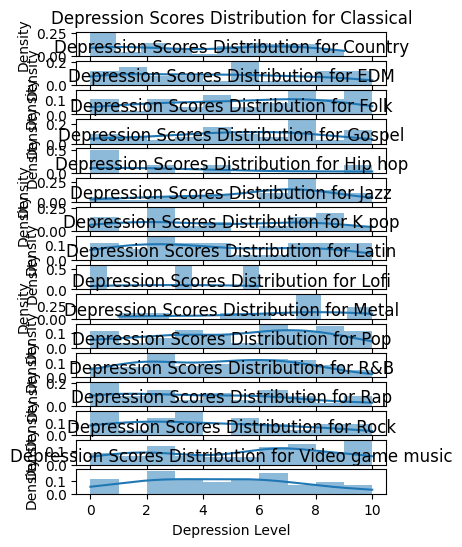

In [198]:


segmented_data = cp.groupby('Fav genre')['Depression'].value_counts().unstack(fill_value=0)

for genre in segmented_data.index:
    plt.figure(figsize=(4, 4))  # Adjust size of each plot
    
    # Plot histogram with KDE curve using seaborn
    sns.histplot(data=cp[cp['Fav genre'] == genre], x='Depression', kde=True, bins=10, stat='density', linewidth=0)
    
    # Customize the plot
    plt.title(f'Depression Scores Distribution for {genre}')
    plt.xlabel('Depression Level')
    plt.ylabel('Density')
    plt.tight_layout()
    
    # Show the plot
    plt.show()
